<a href="https://colab.research.google.com/github/chokkan/deeplearning/blob/master/notebook/convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolution

This notebook demonstrates *convolution matrix* (aka. *kernel*). See: https://en.wikipedia.org/wiki/Kernel_(image_processing)

## Load a sample image (via Pillow: a fork of Python Image Library (PIL))

In [4]:
from PIL import Image
import urllib.request

In [5]:
img = Image.open(urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/2/2c/Flock_of_sheep.jpg'))
img.thumbnail((256,256), Image.LANCZOS) # Resize to half to reduce the size of this notebook.

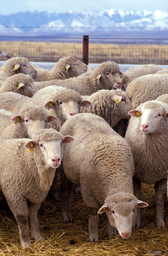

In [6]:
img

## Convert the image into torch.tensor

In [7]:
import torch, torchvision
from torchvision import transforms
from torch import nn

Define utility functions to bridge images and tensors.

In [8]:
to_tensor = transforms.Compose([
   transforms.Grayscale(),  # Convert image to grayscale.
   transforms.ToTensor()    # Converts a PIL Image in the range [0, 255] to a torch.FloatTensor in the range [0.0, 1.0].
])

to_pil = transforms.Compose([
    transforms.ToPILImage()
])

Convert the PIL image object into a torch tensor.

In [9]:
input = to_tensor(img)

The shape of `input` is (channel, width, height).

In [10]:
input.shape

torch.Size([1, 256, 168])

In [11]:
input

tensor([[[0.8706, 0.8706, 0.8745,  ..., 0.9137, 0.9137, 0.9176],
         [0.8588, 0.8627, 0.8706,  ..., 0.9137, 0.9098, 0.9098],
         [0.8588, 0.8588, 0.8588,  ..., 0.9059, 0.9098, 0.9098],
         ...,
         [0.7451, 0.6078, 0.6980,  ..., 0.2314, 0.3059, 0.3020],
         [0.5882, 0.6157, 0.5255,  ..., 0.3922, 0.3255, 0.2863],
         [0.5098, 0.5176, 0.4745,  ..., 0.3176, 0.2902, 0.2667]]])

Confirm that we can convert back to the original image from the tensor.

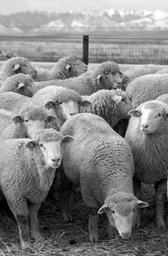

In [12]:
to_pil(input)

## Convolution layer

2D convolution over an input image:

+ `in_channels = 1`: an input is a grayscale image
+ `out_channels = 1`: an output is a grayscale image
+ `kernel_size = (3, 3)`: the kernel (filter) size is 3 x 3
+ `stride = 1`: the stride for the cross-correlation is 1
+ `padding = 1`: zero-paddings on both sides for 1 point for each dimension
+ `bias = False`: no bias parameter (for simplicity)

In [13]:
conv = nn.Conv2d(1, 1, (3, 3), stride=1, padding=1, bias=False)

The code below does not work because the convolution layer requires the dimension for batch.

In [14]:
conv(input)

tensor([[[ 0.7912,  0.9886,  0.9927,  ...,  1.0407,  1.0393,  0.7909],
         [ 0.5225,  0.4346,  0.4382,  ...,  0.4641,  0.4634,  0.4615],
         [ 0.5247,  0.4401,  0.4386,  ...,  0.4626,  0.4635,  0.4618],
         ...,
         [ 0.3835,  0.3151,  0.3574,  ...,  0.2208,  0.1791,  0.1358],
         [ 0.3154,  0.1750,  0.2432,  ...,  0.2082,  0.1882,  0.1386],
         [ 0.0321, -0.0617, -0.1275,  ..., -0.0157, -0.0471,  0.0130]]],
       grad_fn=<SqueezeBackward1>)

We need to insert a dimension for a batch at dim=0.

In [15]:
input = input.unsqueeze(0)

In [16]:
input.shape

torch.Size([1, 1, 256, 168])

In [17]:
output = conv(input)

Setting `padding=1` in the convolution layer, we obtain an image of the same size.

In [18]:
output.shape

torch.Size([1, 1, 256, 168])

We need to remove the first dimension before converting to a PIL object.

In [19]:
output.data.squeeze(dim=0).shape

torch.Size([1, 256, 168])

Display the output from the convolution layer by converting `output` to a PIL object.

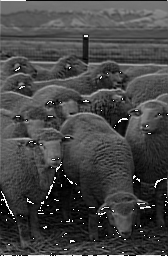

In [20]:
to_pil(output.data.squeeze(dim=0))

Clip every value in the output tensor within the range of [0, 1].

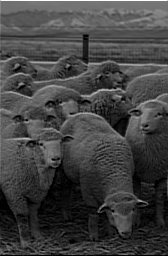

In [21]:
to_pil(torch.clamp(output, 0, 1).data.squeeze(dim=0))

Utility function to show two images in a row.

In [22]:
def display(img1, img2):
    im1 = to_pil(torch.clamp(img1, 0, 1).data.squeeze(dim=0))
    im2 = to_pil(torch.clamp(img2, 0, 1).data.squeeze(dim=0))
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

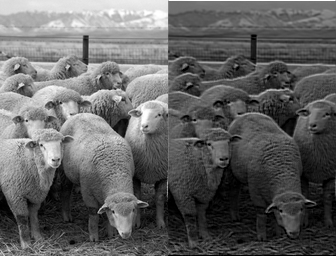

In [23]:
display(input, output)

In [24]:
conv.weight.data

tensor([[[[-0.3235, -0.0334, -0.2692],
          [ 0.1476,  0.3190,  0.1062],
          [ 0.0768,  0.3226,  0.1670]]]])

In [25]:
conv.weight.shape

torch.Size([1, 1, 3, 3])

## Identity

In [26]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1, 0.],
    [0., 0., 0.],
]]])

In [27]:
conv.weight.data

tensor([[[[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]]]])

In [28]:
output = conv(input)

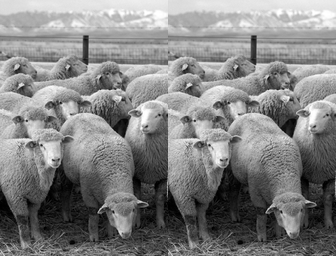

In [29]:
display(input, output)

## Brighten

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 1.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


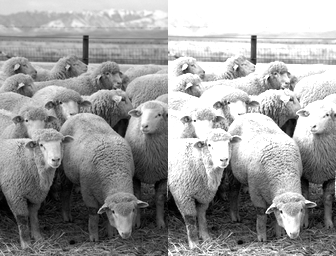

In [30]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 1.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

## Darken

tensor([[[[0.0000, 0.0000, 0.0000],
          [0.0000, 0.5000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])


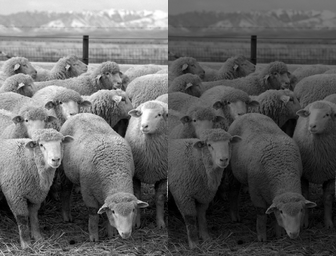

In [31]:
conv.weight.data = torch.tensor([[[
    [0., 0., 0.],
    [0., 0.5, 0.],
    [0., 0., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

## Box blur

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])


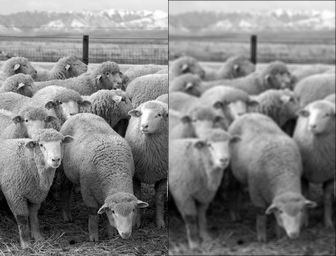

In [32]:
conv.weight.data = torch.ones((1, 1, 3,3), dtype=torch.float) / 9.
print(conv.weight.data)
output = conv(input)
display(input, output)

## Gaussian blur

tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]]]])


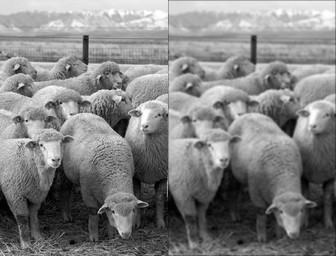

In [33]:
conv.weight.data = torch.tensor([[[
    [1., 2., 1.],
    [2., 4., 2.],
    [1., 2., 1.],
]]])/16.
print(conv.weight.data)
output = conv(input)
display(input, output)

## Sharpen

tensor([[[[ 0., -1.,  0.],
          [-1.,  5., -1.],
          [ 0., -1.,  0.]]]])


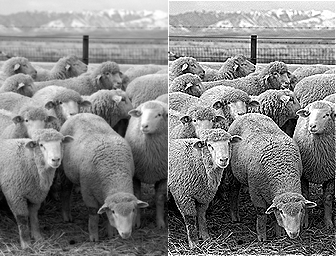

In [34]:
conv.weight.data = torch.tensor([[[
    [0., -1., 0.],
    [-1., 5., -1.],
    [0., -1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

tensor([[[[ 0., -2.,  0.],
          [-2., 10., -2.],
          [ 0., -2.,  0.]]]])


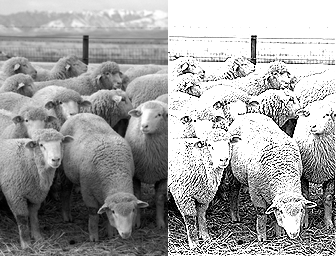

In [35]:
conv.weight.data = torch.tensor([[[
    [0., -2., 0.],
    [-2., 10., -2.],
    [0., -2., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

## Edge detection

tensor([[[[ 0.,  1.,  0.],
          [ 1., -4.,  1.],
          [ 0.,  1.,  0.]]]])


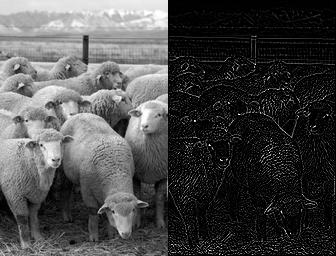

In [36]:
conv.weight.data = torch.tensor([[[
    [0., 1., 0.],
    [1., -4., 1.],
    [0., 1., 0.],
]]])
print(conv.weight.data)
output = conv(input)
display(input, output)

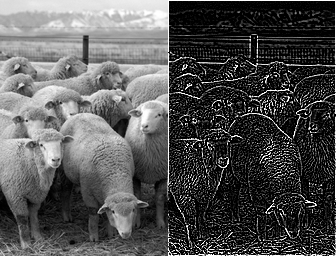

In [37]:
conv.weight.data = torch.tensor([[[
    [-1., -1., -1.],
    [-1., 8., -1.],
    [-1., -1., -1.],
]]])
output = conv(input)
display(input, output)